In [87]:
from collections import Counter
from collections import defaultdict
import string
import numpy as np
import pandas as pd
from nltk import word_tokenize, ngrams
import time

import matplotlib.pyplot as plt


class NgramModel(object):

    def __init__(self, n=1):
        """
        Class init
        :param 'n': length of n-gram, default is one
        """
        self.n = n
        # a nested breakdown of all the words associated
        # before and after the appearance of another word
        self.entropylist = defaultdict(list)
        # keeps track of how many times ngram has appeared in the text before
        self.ngram_counter = {}

    def get_ngrams(self, corpus: list) -> dict:
        """
        Get ngrams
        :param 'corpus' : contents want to process in ngram
        :return         : list of ngrams
        """

        # list of special characters want to be removed from the corpus.
        removals = string.punctuation + '``'+'’'

        for com in corpus:
            ngram_statement = [str(i).lower() for i in ngrams(
                [iter for iter in word_tokenize(com) if iter not in removals], self.n)]
            counter = 0
            recent_list = []
            for gram in ngram_statement:

                # Romovig formatting that applied to the string format
                # when being passed through word_tokenize.
                if self.n == 1:
                    gram_clean = gram[2:len(gram)-3]
                else:
                    gram_clean = ''.join(gram)

                # Depending on the position and length of the gram
                if counter == 0:
                    self.entropylist['[start]'].append(gram_clean)
                    recent_list.append(gram_clean)
                elif counter > 0:
                    self.entropylist[str(
                        recent_list[len(recent_list)-self.n])].append(str(gram_clean))
                    recent_list.append(gram_clean)
                elif counter == len(ngram_statement):
                    self.entropylist[str(
                        recent_list[len(recent_list)-self.n])].append('[end]')
                    recent_list.append('[end]')

                counter += 1

        # usage count represents the appearance
        # of words (in their respective order)
        for key in self.entropylist:
            count_vals = {}
            # increment the appearance of the grams that appear within the gram.
            for val in self.entropylist[key]:
                if str(val) in count_vals:
                    count_vals[str(val)] += 1
                else:
                    count_vals[str(val)] = 1

            self.ngram_counter[str(val)] = [count_vals]

        return {'usage': self.ngram_counter, 'entropylist': self.entropylist}


class MarkovChainModel(object):

    def __init__(self, ngrams):
        """
        Class init
        :param 'ngrams': data structure of the n-gram
        """

        self.ngrams = ngrams

    def _transition_table(self) -> dict:
        """
        Returns the set of transition tables based on the length of n
        :return : set of transition table(s)
        """

        all_entropy = {}
        ngrams = self.ngrams

        for key in ngrams['entropylist']:
            cond_prob_val = {}
            relative_usage = Counter(ngrams['entropylist'][key])
            relative_words_len = sum(relative_usage.values())

            for following_gram in relative_usage:
                cond_prob_val[following_gram] = float(
                    relative_usage[following_gram]) / float(relative_words_len)

            all_entropy[key] = cond_prob_val

        return all_entropy

    def _melt_transition_table(self) -> pd.DataFrame:
        """
        Create a melted dataframe
        :return : dataframe of transition table(s)
        """

        transition_table = self._transition_table()
        flat_output = []
        for key in transition_table:
            for foll in transition_table[key]:
                temp_row = [key, foll, transition_table[key][foll]]
                flat_output.append(temp_row)
        pd_flat = pd.DataFrame(flat_output)
        headers = ['parent', 'relation', 'percentage']
        pd_flat.columns = headers
        pd_flat.to_csv('output.csv')
        return pd_flat

    def get_matrix(self) -> pd.DataFrame:
        """
        Create a markov chain transition matrix
        :return : transition matrix of markov chain
        """
        transition_table = self._melt_transition_table()

        distinct = (list(set(transition_table['parent'].unique())
                    | set(transition_table['relation'].unique())))
        zero_data = np.zeros(shape=(len(distinct), len(distinct)))
        df = pd.DataFrame(index=distinct, columns=distinct, data=zero_data)
        for _, row in transition_table.iterrows():
            df[row['parent']][row['relation']] = row['percentage']
        return df

In [88]:
def get_corpus(path: str) -> list:
    """
    Get corpus from the path file
    :param 'path'   : corpus file path
    :return         : generated corpus
    """
    corpus = ''
    with open(path, mode='r', encoding='utf8') as f:
        corpus = f.readlines()
        corpus = [s.rstrip('\n') for s in corpus]

    return corpus

In [89]:
def strassen_algorithm(matrix, c_word, k):
    """
    Execute Markov chain to get the probability of the word come after current word
    :param 'matrix' : transition matrix of markov chain
    :param 'c_word' : current word
    :param 'k'      : the probability of k+1-th word comes after k-th word
    :return : probability of the next word
    """
    if k == 1:
        print('here strassen')
        return matrix[c_word]
    else:
        res = pd.DataFrame(data=np.identity(len(matrix.index)),
                           index=matrix.index, columns=matrix.columns)

        for _ in range(k):
            res = res.dot(matrix)
            # res = res@matrix
        return res[c_word]


In [90]:
def regular_matrix_multiplication(matrix, c_word, k):
    if k == 1:
        print('here regular')
        return matrix[c_word]
    else:
        res = pd.DataFrame(data=np.identity(len(matrix.index)),
                           index=matrix.index, columns=matrix.columns)
        A = list(matrix.to_numpy())
        B = list(matrix.to_numpy())
        res = [] # final result
        print('here')
        for i in range(len(A)):

            row = [] # the new row in new matrix
            for j in range(len(B[0])):
                
                product = 0 # the new element in the new row
                for v in range(len(A[i])):
                    product += A[i][v] * B[v][j]
                row.append(product) # append sum of product into the new row
                
            res.append(row) # append the new row into the final result
        res = pd.DataFrame(data=np.array(res),index=matrix.index, columns=matrix.columns) 
        return res[c_word]


In [91]:
n = 1
path = r'10_Best_Things_to_Do_in_Tartu.txt'
corpus = get_corpus(path)
ngram_model = NgramModel()
# print(ngram_model.get_ngrams(corpus))

markov_model = MarkovChainModel(ngram_model.get_ngrams(corpus))
matrix = markov_model.get_matrix()

In [92]:
start = time.time()
guess_word_1 = strassen_algorithm(matrix, 'although', 3)
print(f'Language Model creating time with Strassen algorithm: {time.time() - start}')

Language Model creating time with Strassen algorithm: 0.011002302169799805


In [93]:
start = time.time()
guess_word_2 = regular_matrix_multiplication(matrix, 'although', 3)
print(f'Language Model creating time with regular matrix multiplication: {time.time() - start}')

Language Model creating time with regular matrix multiplication: 11.535888910293579


In [94]:
guess_word_2

neighborhoods    0.0
offers           0.0
settlers         0.0
good             0.0
wooden           0.0
                ... 
[start]          0.0
architecture     0.0
during           0.0
ingredients      0.0
hall             0.0
Name: although, Length: 290, dtype: float64

In [95]:
guess_word_2==guess_word_1

neighborhoods     True
offers            True
settlers          True
good              True
wooden            True
                 ...  
[start]           True
architecture      True
during            True
ingredients       True
hall             False
Name: although, Length: 290, dtype: bool

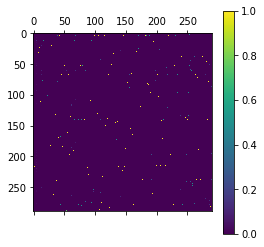

offers           0.000000
link             0.000000
out              0.000000
the              0.000000
long-standing    0.000000
                   ...   
intact           0.003401
architecture     0.000000
ingredients      0.000000
hall             0.000000
either           0.000000
Name: although, Length: 487, dtype: float64


In [96]:
plt.matshow(markov_model.get_matrix())
plt.colorbar()
plt.show()

print(guess_word)